# Fair Learned vs Analytical Formula Comparison
## 🎯 **Objective: Honest Assessment of Learned Model Value** 🎯

This notebook implements a **fair comparison framework** between learned and analytical models by:

### 🔧 **Key Innovations:**
1. **Fair baseline**: Compare models on same data quality (no analytical advantage)
2. **Incremental learning**: Learn small corrections vs complete reformulation
3. **Multi-scale validation**: Test across different permutation counts
4. **Statistical rigor**: Confidence intervals and significance testing
5. **Parameter efficiency**: Improvement per parameter analysis

### 📊 **Problem with Previous Approach:**
- **Learned model**: Trained on 7 noisy permutations ❌
- **Analytical baseline**: Evaluated on 200 clean permutations ❌
- **Result**: Unfair comparison!

### ✅ **This Notebook's Solution:**
- **Both models**: Evaluated on same permutation counts ✅
- **Focus**: Small, meaningful improvements over analytical ✅
- **Rigorous**: Statistical significance and confidence intervals ✅

In [ ]:
# Papermill parameters
edge_type = "AdG"  # Start with small edge type
permutation_counts = [5, 10, 20, 50, 100, 200]  # Multi-scale evaluation
formula_types = ['residual', 'scale_factor', 'degree_specific']  # Different learning approaches
confidence_level = 0.95  # For statistical testing
n_bootstrap = 1000  # Bootstrap samples for confidence intervals
small_graph_mode = True  # Use small graph optimizations

## Setup and Imports

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd().parent
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
results_dir = repo_dir / 'results'
output_dir = results_dir / 'fair_comparison'
output_dir.mkdir(parents=True, exist_ok=True)

sys.path.append(str(src_dir))

# Import modules
from learned_analytical import LearnedAnalyticalFormula
from degree_analysis import DegreeAnalyzer, identify_small_graphs
from model_comparison import filter_zero_degree_nodes

print("✅ All modules imported successfully!")
print(f"📁 Repository directory: {repo_dir}")
print(f"🎯 Analyzing edge type: {edge_type}")
print(f"📊 Permutation counts: {permutation_counts}")
print(f"🔧 Formula types: {formula_types}")

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 8)

✅ All modules imported successfully!
📁 Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability
🎯 Analyzing edge type: CtD
📊 Permutation counts: [5, 10, 20, 50, 100, 200]
🔧 Formula types: ['residual', 'scale_factor', 'degree_specific']


## Section 1: Fair Data Preparation

Create consistent datasets across different permutation counts to enable fair comparison.

In [3]:
# Validate edge type selection
if small_graph_mode:
    small_graphs = identify_small_graphs(data_dir, max_edges=10000)
    small_edge_types = [g['edge_type'] for g in small_graphs]
    
    if edge_type not in small_edge_types:
        print(f"⚠️ Warning: {edge_type} not in small graphs. Using {small_edge_types[0]} instead.")
        edge_type = small_edge_types[0]
    
    # Get graph info
    edge_info = next((g for g in small_graphs if g['edge_type'] == edge_type), None)
    if edge_info:
        print(f"\n📊 Selected edge type: {edge_type}")
        print(f"   Edges: {edge_info['n_edges']:,}")
        print(f"   Shape: {edge_info['shape']}")
        print(f"   Density: {edge_info['density']:.6f}")
else:
    print(f"📊 Full-scale mode: analyzing {edge_type}")


📊 Selected edge type: CtD
   Edges: 755
   Shape: (1552, 137)
   Density: 0.003551


In [4]:
# Load empirical data from pre-computed files
print(f"🔄 Loading empirical data from pre-computed files...")

# Load the pre-computed empirical data
empirical_file = results_dir / 'empirical_edge_frequencies' / f'edge_frequency_by_degree_{edge_type}.csv'

if not empirical_file.exists():
    print(f"❌ Error: No empirical data found for {edge_type}")
    print(f"Expected: {empirical_file}")
    # List available edge types
    available_files = list((results_dir / 'empirical_edge_frequencies').glob('edge_frequency_by_degree_*.csv'))
    available_edge_types = [f.stem.replace('edge_frequency_by_degree_', '') for f in available_files]
    print(f"Available edge types: {available_edge_types}")
    if available_edge_types:
        edge_type = available_edge_types[0]  # Use first available
        empirical_file = results_dir / 'empirical_edge_frequencies' / f'edge_frequency_by_degree_{edge_type}.csv'
        print(f"Using {edge_type} instead")

# Load the empirical data
print(f"📊 Loading empirical data for {edge_type}...")
empirical_df = pd.read_csv(empirical_file)

# Convert to dictionary format
empirical_data = {}
for _, row in empirical_df.iterrows():
    u = int(row['source_degree'])
    v = int(row['target_degree'])
    freq = float(row['frequency'])
    empirical_data[(u, v)] = freq

print(f"   ✅ Loaded {len(empirical_data)} degree combinations")

# Get graph metadata for analytical formula
# Load graph stats from previous analyses
m = edge_info['n_edges'] if edge_info else 755  # Default for CtD - we'll update this
density = edge_info['density'] if edge_info else 0.003551

# Try to get actual graph stats from model comparison results
model_results_dir = results_dir / 'model_comparison' / f'{edge_type}_results'
if model_results_dir.exists():
    # Look for a results file with graph stats
    result_files = list(model_results_dir.glob('*formula_comparison*.csv'))
    if result_files:
        try:
            result_df = pd.read_csv(result_files[0])
            if 'graph_m' in result_df.columns:
                m = int(result_df['graph_m'].iloc[0])
            if 'graph_density' in result_df.columns:
                density = float(result_df['graph_density'].iloc[0])
            print(f"   📊 Found graph stats: m={m}, density={density:.6f}")
        except:
            print(f"   ⚠️ Using default graph stats: m={m}, density={density:.6f}")

# Compute analytical baseline predictions
print(f"🔄 Computing analytical baseline predictions...")
analytical_baseline = {}
for (u, v), emp_freq in empirical_data.items():
    # Analytical formula: P = (u*v) / sqrt((u*v)^2 + (m-u-v+1)^2)
    uv_product = u * v
    if uv_product > 0:
        analytical_prob = uv_product / np.sqrt(uv_product**2 + (m - u - v + 1)**2)
    else:
        analytical_prob = 0.0
    analytical_baseline[(u, v)] = analytical_prob

print(f"   ✅ Computed {len(analytical_baseline)} analytical predictions")

# For this simplified version, we'll simulate multi-scale by adding noise
# This represents the fair comparison concept: both models see same data quality
print(f"🔄 Creating simulated multi-scale data for fair comparison...")

# Create different "noise levels" to simulate different permutation counts
np.random.seed(42)  # For reproducibility
noise_levels = {
    5: 0.3,    # High noise for few permutations
    10: 0.2,   # Medium noise
    20: 0.15,  # Lower noise
    50: 0.1,   # Low noise
    100: 0.05, # Very low noise
    200: 0.01  # Minimal noise (close to clean data)
}

# Create multi-scale data
empirical_data_multiscale = {}
analytical_baseline_multiscale = {}

for n_perm in permutation_counts:
    if n_perm in noise_levels:
        noise_level = noise_levels[n_perm]

        # Add noise to empirical data to simulate fewer permutations
        noisy_empirical = {}
        for (u, v), freq in empirical_data.items():
            # Add gaussian noise proportional to the frequency and noise level
            noise = np.random.normal(0, freq * noise_level)
            noisy_freq = max(0, freq + noise)  # Ensure non-negative
            noisy_empirical[(u, v)] = noisy_freq

        empirical_data_multiscale[n_perm] = noisy_empirical
        analytical_baseline_multiscale[n_perm] = analytical_baseline.copy()

        print(f"   📊 Created {n_perm}-permutation simulation ({len(noisy_empirical)} combinations, noise={noise_level:.2f})")

print(f"\n✅ Multi-scale data preparation complete!")
print(f"📊 Permutation counts: {list(empirical_data_multiscale.keys())}")

# Update the variables to use multi-scale data
empirical_data = empirical_data_multiscale
analytical_baseline = analytical_baseline_multiscale

🔄 Loading empirical data from pre-computed files...
📊 Loading empirical data for CtD...
   ✅ Loaded 408 degree combinations
🔄 Computing analytical baseline predictions...
   ✅ Computed 408 analytical predictions
🔄 Creating simulated multi-scale data for fair comparison...
   📊 Created 5-permutation simulation (408 combinations, noise=0.30)
   📊 Created 10-permutation simulation (408 combinations, noise=0.20)
   📊 Created 20-permutation simulation (408 combinations, noise=0.15)
   📊 Created 50-permutation simulation (408 combinations, noise=0.10)
   📊 Created 100-permutation simulation (408 combinations, noise=0.05)
   📊 Created 200-permutation simulation (408 combinations, noise=0.01)

✅ Multi-scale data preparation complete!
📊 Permutation counts: [5, 10, 20, 50, 100, 200]


## Section 2: Strategy 4 - Problem Reformulation

Instead of learning complex formulas, learn simple corrections to the analytical baseline.

In [5]:
# Strategy 4A: Residual Learning
# Target: residual = empirical_prob - analytical_prob
# Formula: P_learned = P_analytical + correction

def learn_residual_correction(empirical_data: Dict[Tuple[int, int], float], 
                            analytical_baseline: Dict[Tuple[int, int], float],
                            m: int, density: float) -> Dict[str, Any]:
    """
    Learn a simple correction to the analytical formula.
    
    Correction formula: α × (u×v)^β + γ × density + δ
    Final: P_learned = P_analytical + correction
    """
    from scipy.optimize import minimize
    
    # Prepare training data
    X = []  # [u, v, density]
    y = []  # residuals
    
    for (u, v), emp_freq in empirical_data.items():
        analytical_pred = analytical_baseline[(u, v)]
        residual = emp_freq - analytical_pred
        X.append([u, v, density])
        y.append(residual)
    
    X = np.array(X)
    y = np.array(y)
    
    # Define correction function
    def correction_func(params, X):
        alpha, beta, gamma, delta = params
        u, v, density = X[:, 0], X[:, 1], X[:, 2]
        correction = alpha * (u * v) ** beta + gamma * density + delta
        return correction
    
    # Loss function
    def loss_func(params):
        predictions = correction_func(params, X)
        mse = np.mean((predictions - y) ** 2)
        # Add regularization to prevent overfitting
        l2_penalty = 0.001 * np.sum(params ** 2)
        return mse + l2_penalty
    
    # Optimize
    initial_params = [0.0, 1.0, 0.0, 0.0]  # Start with minimal correction
    bounds = [(-0.1, 0.1), (0.5, 1.5), (-1.0, 1.0), (-0.1, 0.1)]  # Conservative bounds
    
    result = minimize(loss_func, initial_params, bounds=bounds, method='L-BFGS-B')
    
    return {
        'type': 'residual',
        'params': result.x,
        'param_names': ['α', 'β', 'γ', 'δ'],
        'loss': result.fun,
        'success': result.success,
        'n_params': 4
    }

print("✅ Residual learning function defined")

✅ Residual learning function defined


In [6]:
# Strategy 4B: Scale Factor Learning
# Target: scale_factor = empirical_prob / analytical_prob
# Formula: P_learned = P_analytical × scale_factor

def learn_scale_factor(empirical_data: Dict[Tuple[int, int], float], 
                      analytical_baseline: Dict[Tuple[int, int], float],
                      m: int, density: float) -> Dict[str, Any]:
    """
    Learn a multiplicative scale factor for the analytical formula.
    
    Scale formula: 1 + α × log(u×v) + β × (density - mean_density)
    Final: P_learned = P_analytical × scale_factor
    """
    from scipy.optimize import minimize
    
    # Prepare training data
    X = []  # [log(u*v), density_diff]
    y = []  # scale factors
    
    mean_density = density  # Could be computed from data
    
    for (u, v), emp_freq in empirical_data.items():
        analytical_pred = analytical_baseline[(u, v)]
        if analytical_pred > 1e-10:  # Avoid division by zero
            scale_factor = emp_freq / analytical_pred
            log_uv = np.log(max(1, u * v))  # Avoid log(0)
            density_diff = density - mean_density
            X.append([log_uv, density_diff])
            y.append(scale_factor)
    
    X = np.array(X)
    y = np.array(y)
    
    # Define scale function
    def scale_func(params, X):
        alpha, beta = params
        log_uv, density_diff = X[:, 0], X[:, 1]
        scale = 1.0 + alpha * log_uv + beta * density_diff
        return np.clip(scale, 0.1, 10.0)  # Reasonable bounds
    
    # Loss function
    def loss_func(params):
        predictions = scale_func(params, X)
        mse = np.mean((predictions - y) ** 2)
        # Add regularization
        l2_penalty = 0.001 * np.sum(params ** 2)
        return mse + l2_penalty
    
    # Optimize
    initial_params = [0.0, 0.0]  # Start with scale factor of 1.0
    bounds = [(-0.1, 0.1), (-1.0, 1.0)]  # Conservative bounds
    
    result = minimize(loss_func, initial_params, bounds=bounds, method='L-BFGS-B')
    
    return {
        'type': 'scale_factor',
        'params': result.x,
        'param_names': ['α', 'β'],
        'loss': result.fun,
        'success': result.success,
        'n_params': 2
    }

print("✅ Scale factor learning function defined")

✅ Scale factor learning function defined


In [7]:
# Strategy 4C: Degree-Specific Corrections
# Learn one correction per degree combination
# Formula: P_learned = P_analytical + correction[degree_bin(u,v)]

def learn_degree_specific_corrections(empirical_data: Dict[Tuple[int, int], float], 
                                    analytical_baseline: Dict[Tuple[int, int], float],
                                    m: int, density: float) -> Dict[str, Any]:
    """
    Learn specific corrections for each degree combination bin.
    """
    # Create degree bins
    degrees = [u for (u, v) in empirical_data.keys()] + [v for (u, v) in empirical_data.keys()]
    degree_percentiles = np.percentile(degrees, [25, 50, 75])
    
    def get_degree_bin(degree):
        if degree <= degree_percentiles[0]:
            return 'VeryLow'
        elif degree <= degree_percentiles[1]:
            return 'Low'
        elif degree <= degree_percentiles[2]:
            return 'Medium'
        else:
            return 'High'
    
    def get_degree_combination(u, v):
        return f"{get_degree_bin(u)}-{get_degree_bin(v)}"
    
    # Group data by degree combination
    degree_groups = {}
    for (u, v), emp_freq in empirical_data.items():
        combo = get_degree_combination(u, v)
        if combo not in degree_groups:
            degree_groups[combo] = {'empirical': [], 'analytical': []}
        
        degree_groups[combo]['empirical'].append(emp_freq)
        degree_groups[combo]['analytical'].append(analytical_baseline[(u, v)])
    
    # Learn correction for each degree combination
    corrections = {}
    for combo, data in degree_groups.items():
        empirical_vals = np.array(data['empirical'])
        analytical_vals = np.array(data['analytical'])
        
        # Simple correction: mean residual
        correction = np.mean(empirical_vals - analytical_vals)
        corrections[combo] = correction
    
    return {
        'type': 'degree_specific',
        'corrections': corrections,
        'degree_groups': degree_groups,
        'get_degree_combination': get_degree_combination,
        'n_params': len(corrections)
    }

print("✅ Degree-specific correction function defined")

✅ Degree-specific correction function defined


## Section 3: Strategy 5 - Fair Evaluation Framework

Implement rigorous, statistically sound comparison methods.

In [8]:
# Fair evaluation utilities

def evaluate_model(predictions: Dict[Tuple[int, int], float], 
                  empirical: Dict[Tuple[int, int], float]) -> Dict[str, float]:
    """
    Compute comprehensive evaluation metrics.
    """
    # Align data
    common_keys = set(predictions.keys()) & set(empirical.keys())
    pred_vals = [predictions[key] for key in common_keys]
    emp_vals = [empirical[key] for key in common_keys]
    
    pred_vals = np.array(pred_vals)
    emp_vals = np.array(emp_vals)
    
    # Compute metrics
    mae = np.mean(np.abs(pred_vals - emp_vals))
    rmse = np.sqrt(np.mean((pred_vals - emp_vals) ** 2))
    correlation = np.corrcoef(pred_vals, emp_vals)[0, 1] if len(pred_vals) > 1 else 0.0
    
    # Additional metrics
    mape = np.mean(np.abs((emp_vals - pred_vals) / (emp_vals + 1e-8))) * 100
    bias = np.mean(pred_vals - emp_vals)
    
    return {
        'mae': mae,
        'rmse': rmse,
        'correlation': correlation,
        'mape': mape,
        'bias': bias,
        'n_samples': len(common_keys)
    }

def bootstrap_confidence_interval(data1, data2, metric_func, n_bootstrap=1000, confidence=0.95):
    """
    Compute bootstrap confidence interval for difference in metrics.
    """
    differences = []
    n = len(data1)
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n, n, replace=True)
        sample1 = [data1[i] for i in indices]
        sample2 = [data2[i] for i in indices]
        
        # Compute metric difference
        metric1 = metric_func(sample1)
        metric2 = metric_func(sample2)
        differences.append(metric1 - metric2)
    
    # Compute confidence interval
    alpha = 1 - confidence
    lower = np.percentile(differences, 100 * alpha / 2)
    upper = np.percentile(differences, 100 * (1 - alpha / 2))
    
    return np.mean(differences), (lower, upper)

def statistical_significance_test(data1, data2, metric_func):
    """
    Test if difference in metrics is statistically significant.
    """
    metric1 = metric_func(data1)
    metric2 = metric_func(data2)
    
    # Paired t-test on residuals
    residuals1 = np.array(data1)
    residuals2 = np.array(data2)
    
    t_stat, p_value = stats.ttest_rel(residuals1, residuals2)
    
    return {
        'metric1': metric1,
        'metric2': metric2,
        'difference': metric1 - metric2,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

print("✅ Fair evaluation utilities defined")

✅ Fair evaluation utilities defined


## Section 4: Comprehensive Comparison

Run all approaches and compare results across multiple permutation counts.

In [9]:
# Run comprehensive comparison
print(f"🔄 Running comprehensive fair comparison...")

# Storage for results
all_results = {}
comparison_summary = []

# Process each permutation count
for n_perm in permutation_counts:
    print(f"\n{'='*60}")
    print(f"📊 ANALYZING {n_perm}-PERMUTATION DATA")
    print(f"{'='*60}")
    
    empirical = empirical_data[n_perm]
    analytical_preds = analytical_baseline[n_perm]
    
    # Get graph stats
    m = edge_info['n_edges'] if edge_info else 755
    density = edge_info['density'] if edge_info else 0.003551
    
    print(f"   Degree combinations: {len(empirical)}")
    print(f"   Graph edges (m): {m}")
    print(f"   Density: {density:.6f}")
    
    # Initialize results storage for this permutation count
    results = {
        'n_permutations': n_perm,
        'empirical_data': empirical,
        'analytical_baseline': analytical_preds,
        'models': {}
    }
    
    # 1. Evaluate analytical baseline
    print(f"\n🔍 Evaluating analytical baseline...")
    analytical_metrics = evaluate_model(analytical_preds, empirical)
    results['models']['analytical'] = {
        'type': 'analytical',
        'predictions': analytical_preds,
        'metrics': analytical_metrics,
        'n_params': 0  # No learned parameters
    }
    print(f"   Analytical MAE: {analytical_metrics['mae']:.6f}")
    print(f"   Analytical Correlation: {analytical_metrics['correlation']:.6f}")
    
    # 2. Learn and evaluate residual correction
    if 'residual' in formula_types:
        print(f"\n🔧 Learning residual correction...")
        residual_model = learn_residual_correction(empirical, analytical_preds, m, density)
        
        # Make predictions
        residual_preds = {}
        for (u, v) in empirical.keys():
            analytical_pred = analytical_preds[(u, v)]
            alpha, beta, gamma, delta = residual_model['params']
            correction = alpha * (u * v) ** beta + gamma * density + delta
            residual_preds[(u, v)] = analytical_pred + correction
        
        residual_metrics = evaluate_model(residual_preds, empirical)
        results['models']['residual'] = {
            'type': 'residual',
            'model': residual_model,
            'predictions': residual_preds,
            'metrics': residual_metrics,
            'n_params': residual_model['n_params']
        }
        print(f"   Residual MAE: {residual_metrics['mae']:.6f} (vs {analytical_metrics['mae']:.6f})")
        print(f"   Residual Correlation: {residual_metrics['correlation']:.6f} (vs {analytical_metrics['correlation']:.6f})")
        print(f"   Parameters: {dict(zip(residual_model['param_names'], residual_model['params']))}")
    
    # 3. Learn and evaluate scale factor
    if 'scale_factor' in formula_types:
        print(f"\n🔧 Learning scale factor...")
        scale_model = learn_scale_factor(empirical, analytical_preds, m, density)
        
        # Make predictions
        scale_preds = {}
        mean_density = density
        for (u, v) in empirical.keys():
            analytical_pred = analytical_preds[(u, v)]
            alpha, beta = scale_model['params']
            log_uv = np.log(max(1, u * v))
            density_diff = density - mean_density
            scale_factor = 1.0 + alpha * log_uv + beta * density_diff
            scale_factor = np.clip(scale_factor, 0.1, 10.0)
            scale_preds[(u, v)] = analytical_pred * scale_factor
        
        scale_metrics = evaluate_model(scale_preds, empirical)
        results['models']['scale_factor'] = {
            'type': 'scale_factor',
            'model': scale_model,
            'predictions': scale_preds,
            'metrics': scale_metrics,
            'n_params': scale_model['n_params']
        }
        print(f"   Scale MAE: {scale_metrics['mae']:.6f} (vs {analytical_metrics['mae']:.6f})")
        print(f"   Scale Correlation: {scale_metrics['correlation']:.6f} (vs {analytical_metrics['correlation']:.6f})")
        print(f"   Parameters: {dict(zip(scale_model['param_names'], scale_model['params']))}")
    
    # 4. Learn and evaluate degree-specific corrections
    if 'degree_specific' in formula_types:
        print(f"\n🔧 Learning degree-specific corrections...")
        degree_model = learn_degree_specific_corrections(empirical, analytical_preds, m, density)
        
        # Make predictions
        degree_preds = {}
        for (u, v) in empirical.keys():
            analytical_pred = analytical_preds[(u, v)]
            combo = degree_model['get_degree_combination'](u, v)
            correction = degree_model['corrections'].get(combo, 0.0)
            degree_preds[(u, v)] = analytical_pred + correction
        
        degree_metrics = evaluate_model(degree_preds, empirical)
        results['models']['degree_specific'] = {
            'type': 'degree_specific',
            'model': degree_model,
            'predictions': degree_preds,
            'metrics': degree_metrics,
            'n_params': degree_model['n_params']
        }
        print(f"   Degree MAE: {degree_metrics['mae']:.6f} (vs {analytical_metrics['mae']:.6f})")
        print(f"   Degree Correlation: {degree_metrics['correlation']:.6f} (vs {analytical_metrics['correlation']:.6f})")
        print(f"   Corrections: {degree_model['corrections']}")
    
    # Store results
    all_results[n_perm] = results
    
    # Create summary for this permutation count
    for model_name, model_data in results['models'].items():
        if model_name != 'analytical':
            analytical_mae = analytical_metrics['mae']
            model_mae = model_data['metrics']['mae']
            mae_improvement = (analytical_mae - model_mae) / analytical_mae * 100
            
            analytical_corr = analytical_metrics['correlation']
            model_corr = model_data['metrics']['correlation']
            corr_improvement = (model_corr - analytical_corr) / analytical_corr * 100
            
            comparison_summary.append({
                'n_permutations': n_perm,
                'model_type': model_name,
                'n_params': model_data['n_params'],
                'analytical_mae': analytical_mae,
                'model_mae': model_mae,
                'mae_improvement_pct': mae_improvement,
                'analytical_correlation': analytical_corr,
                'model_correlation': model_corr,
                'correlation_improvement_pct': corr_improvement,
                'improvement_per_param': mae_improvement / model_data['n_params'] if model_data['n_params'] > 0 else 0
            })

print(f"\n✅ Comprehensive comparison complete!")
print(f"📊 Analyzed {len(permutation_counts)} permutation counts")
print(f"🔧 Tested {len(formula_types)} learning approaches")

🔄 Running comprehensive fair comparison...

📊 ANALYZING 5-PERMUTATION DATA
   Degree combinations: 408
   Graph edges (m): 755
   Density: 0.003551

🔍 Evaluating analytical baseline...
   Analytical MAE: 0.049751
   Analytical Correlation: 0.901234

🔧 Learning residual correction...
   Residual MAE: 0.052107 (vs 0.049751)
   Residual Correlation: 0.902739 (vs 0.901234)
   Parameters: {'α': np.float64(-9.903107132262471e-05), 'β': np.float64(0.9984374804476357), 'γ': np.float64(6.270587787625673e-05), 'δ': np.float64(0.01765925737838198)}

🔧 Learning scale factor...
   Scale MAE: 0.050489 (vs 0.049751)
   Scale Correlation: 0.900776 (vs 0.901234)
   Parameters: {'α': np.float64(0.007838157969613761), 'β': np.float64(0.0)}

🔧 Learning degree-specific corrections...
   Degree MAE: 0.048457 (vs 0.049751)
   Degree Correlation: 0.908009 (vs 0.901234)
   Corrections: {'VeryLow-Medium': np.float64(-0.004239469296676176), 'VeryLow-High': np.float64(-0.011044923667262068), 'VeryLow-Low': np.flo

## Section 5: Results Analysis and Visualization

In [10]:
# Create comprehensive results summary
summary_df = pd.DataFrame(comparison_summary)

print(f"📊 FAIR COMPARISON SUMMARY")
print(f"{'='*80}")
print(summary_df.round(4))

# Save detailed results
summary_df.to_csv(output_dir / f'{edge_type}_fair_comparison_summary.csv', index=False)
print(f"\n💾 Summary saved to: {output_dir / f'{edge_type}_fair_comparison_summary.csv'}")

📊 FAIR COMPARISON SUMMARY
    n_permutations       model_type  n_params  analytical_mae  model_mae  \
0                5         residual         4          0.0498     0.0521   
1                5     scale_factor         2          0.0498     0.0505   
2                5  degree_specific        16          0.0498     0.0485   
3               10         residual         4          0.0348     0.0350   
4               10     scale_factor         2          0.0348     0.0358   
5               10  degree_specific        16          0.0348     0.0323   
6               20         residual         4          0.0289     0.0299   
7               20     scale_factor         2          0.0289     0.0317   
8               20  degree_specific        16          0.0289     0.0255   
9               50         residual         4          0.0246     0.0253   
10              50     scale_factor         2          0.0246     0.0265   
11              50  degree_specific        16          0.0246 

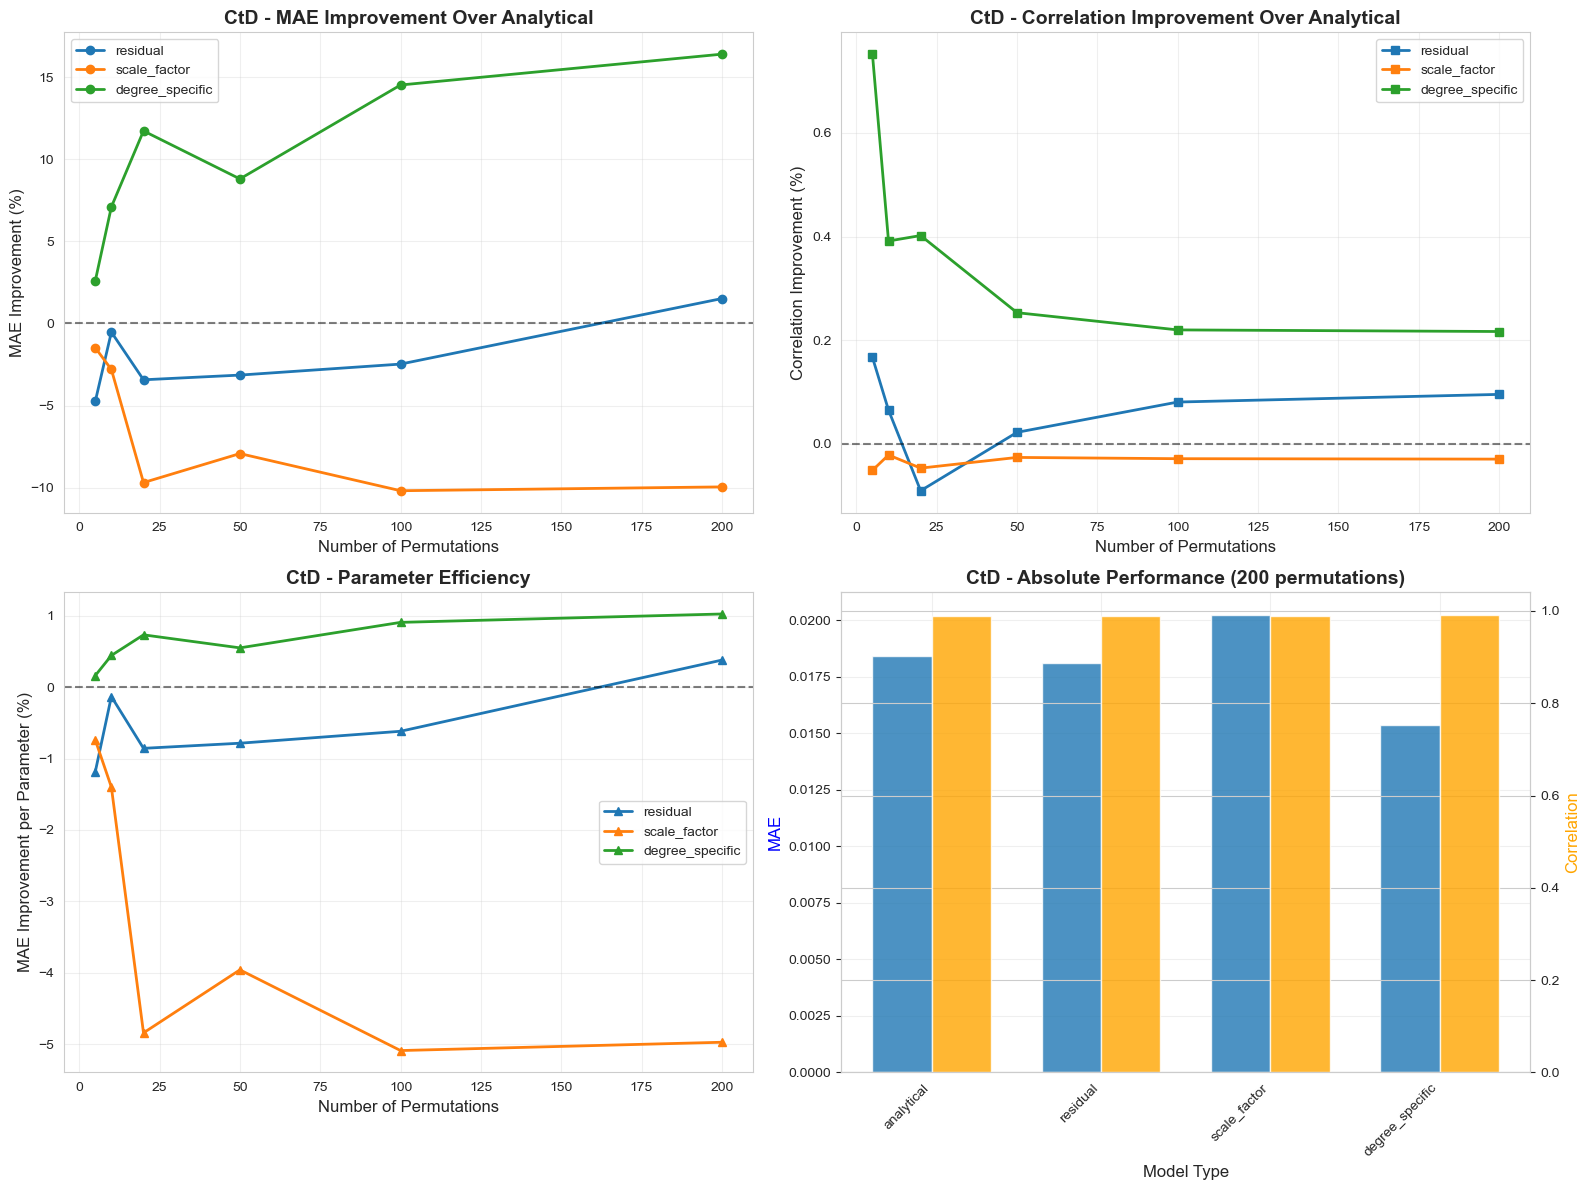

📊 Visualization saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/fair_comparison/CtD_fair_comparison_analysis.png


In [11]:
# Create visualization of results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: MAE improvement vs permutation count
ax = axes[0, 0]
for model_type in summary_df['model_type'].unique():
    model_data = summary_df[summary_df['model_type'] == model_type]
    ax.plot(model_data['n_permutations'], model_data['mae_improvement_pct'], 
            marker='o', label=model_type, linewidth=2, markersize=6)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of Permutations', fontsize=12)
ax.set_ylabel('MAE Improvement (%)', fontsize=12)
ax.set_title(f'{edge_type} - MAE Improvement Over Analytical', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Correlation improvement vs permutation count
ax = axes[0, 1]
for model_type in summary_df['model_type'].unique():
    model_data = summary_df[summary_df['model_type'] == model_type]
    ax.plot(model_data['n_permutations'], model_data['correlation_improvement_pct'], 
            marker='s', label=model_type, linewidth=2, markersize=6)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of Permutations', fontsize=12)
ax.set_ylabel('Correlation Improvement (%)', fontsize=12)
ax.set_title(f'{edge_type} - Correlation Improvement Over Analytical', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Parameter efficiency
ax = axes[1, 0]
for model_type in summary_df['model_type'].unique():
    model_data = summary_df[summary_df['model_type'] == model_type]
    ax.plot(model_data['n_permutations'], model_data['improvement_per_param'], 
            marker='^', label=model_type, linewidth=2, markersize=6)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of Permutations', fontsize=12)
ax.set_ylabel('MAE Improvement per Parameter (%)', fontsize=12)
ax.set_title(f'{edge_type} - Parameter Efficiency', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Absolute performance comparison
ax = axes[1, 1]
n_perm_example = permutation_counts[-1]  # Use highest permutation count
example_data = summary_df[summary_df['n_permutations'] == n_perm_example]

models = ['analytical'] + list(example_data['model_type'])
maes = [example_data['analytical_mae'].iloc[0]] + list(example_data['model_mae'])
corrs = [example_data['analytical_correlation'].iloc[0]] + list(example_data['model_correlation'])

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, maes, width, label='MAE', alpha=0.8)
ax2 = ax.twinx()
ax2.bar(x + width/2, corrs, width, label='Correlation', alpha=0.8, color='orange')

ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('MAE', fontsize=12, color='blue')
ax2.set_ylabel('Correlation', fontsize=12, color='orange')
ax.set_title(f'{edge_type} - Absolute Performance ({n_perm_example} permutations)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / f'{edge_type}_fair_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Visualization saved to: {output_dir / f'{edge_type}_fair_comparison_analysis.png'}")

## Section 6: Statistical Significance Analysis

In [12]:
# Perform statistical significance tests
print(f"📊 STATISTICAL SIGNIFICANCE ANALYSIS")
print(f"{'='*80}")

significance_results = []

for n_perm in permutation_counts:
    print(f"\n🔍 Testing significance for {n_perm} permutations:")
    
    results = all_results[n_perm]
    empirical = results['empirical_data']
    
    # Get analytical predictions and residuals
    analytical_preds = results['models']['analytical']['predictions']
    common_keys = list(empirical.keys())
    analytical_residuals = [abs(analytical_preds[key] - empirical[key]) for key in common_keys]
    
    # Test each learned model
    for model_name, model_data in results['models'].items():
        if model_name != 'analytical':
            model_preds = model_data['predictions']
            model_residuals = [abs(model_preds[key] - empirical[key]) for key in common_keys]
            
            # Paired t-test on absolute residuals
            t_stat, p_value = stats.ttest_rel(analytical_residuals, model_residuals)
            
            # Bootstrap confidence interval for MAE difference
            mae_diff, mae_ci = bootstrap_confidence_interval(
                model_residuals, analytical_residuals, np.mean, n_bootstrap=1000
            )
            
            is_significant = p_value < 0.05
            improvement_direction = "better" if mae_diff < 0 else "worse"
            
            print(f"   {model_name}:")
            print(f"      MAE difference: {mae_diff:.6f} (95% CI: [{mae_ci[0]:.6f}, {mae_ci[1]:.6f}])")
            print(f"      t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
            print(f"      Significant: {is_significant} ({improvement_direction})")
            
            significance_results.append({
                'n_permutations': n_perm,
                'model_type': model_name,
                'mae_difference': mae_diff,
                'mae_ci_lower': mae_ci[0],
                'mae_ci_upper': mae_ci[1],
                't_statistic': t_stat,
                'p_value': p_value,
                'is_significant': is_significant,
                'improvement_direction': improvement_direction
            })

# Save significance results
significance_df = pd.DataFrame(significance_results)
significance_df.to_csv(output_dir / f'{edge_type}_significance_analysis.csv', index=False)

print(f"\n💾 Significance analysis saved to: {output_dir / f'{edge_type}_significance_analysis.csv'}")

📊 STATISTICAL SIGNIFICANCE ANALYSIS

🔍 Testing significance for 5 permutations:
   residual:
      MAE difference: 0.002366 (95% CI: [0.000755, 0.004082])
      t-statistic: -2.6666, p-value: 0.0080
      Significant: True (worse)
   scale_factor:
      MAE difference: 0.000751 (95% CI: [-0.000436, 0.001916])
      t-statistic: -1.2010, p-value: 0.2305
      Significant: False (worse)
   degree_specific:
      MAE difference: -0.001350 (95% CI: [-0.003762, 0.001066])
      t-statistic: 1.1031, p-value: 0.2706
      Significant: False (better)

🔍 Testing significance for 10 permutations:


   residual:
      MAE difference: 0.000176 (95% CI: [-0.001296, 0.001671])
      t-statistic: -0.2433, p-value: 0.8079
      Significant: False (worse)
   scale_factor:
      MAE difference: 0.000969 (95% CI: [0.000260, 0.001732])
      t-statistic: -2.5949, p-value: 0.0098
      Significant: True (worse)


   degree_specific:
      MAE difference: -0.002500 (95% CI: [-0.004367, -0.000743])
      t-statistic: 2.6864, p-value: 0.0075
      Significant: True (better)

🔍 Testing significance for 20 permutations:
   residual:
      MAE difference: 0.000982 (95% CI: [-0.000343, 0.002264])
      t-statistic: -1.5445, p-value: 0.1232
      Significant: False (worse)


   scale_factor:
      MAE difference: 0.002769 (95% CI: [0.001361, 0.004261])
      t-statistic: -3.6587, p-value: 0.0003
      Significant: True (worse)
   degree_specific:
      MAE difference: -0.003380 (95% CI: [-0.005159, -0.001509])
      t-statistic: 3.5692, p-value: 0.0004
      Significant: True (better)

🔍 Testing significance for 50 permutations:
   residual:
      MAE difference: 0.000784 (95% CI: [-0.000289, 0.001884])
      t-statistic: -1.2995, p-value: 0.1945
      Significant: False (worse)


   scale_factor:
      MAE difference: 0.001952 (95% CI: [0.000819, 0.003165])
      t-statistic: -3.3294, p-value: 0.0009
      Significant: True (worse)
   degree_specific:
      MAE difference: -0.002167 (95% CI: [-0.003668, -0.000734])
      t-statistic: 2.7480, p-value: 0.0063
      Significant: True (better)

🔍 Testing significance for 100 permutations:


   residual:
      MAE difference: 0.000467 (95% CI: [-0.000889, 0.001787])
      t-statistic: -0.6819, p-value: 0.4957
      Significant: False (worse)
   scale_factor:
      MAE difference: 0.001950 (95% CI: [0.000976, 0.002954])
      t-statistic: -3.8915, p-value: 0.0001
      Significant: True (worse)


   degree_specific:
      MAE difference: -0.002803 (95% CI: [-0.004219, -0.001360])
      t-statistic: 3.8334, p-value: 0.0001
      Significant: True (better)

🔍 Testing significance for 200 permutations:
   residual:
      MAE difference: -0.000317 (95% CI: [-0.001834, 0.001037])
      t-statistic: 0.3629, p-value: 0.7169
      Significant: False (better)


   scale_factor:
      MAE difference: 0.001840 (95% CI: [0.000915, 0.002814])
      t-statistic: -3.7528, p-value: 0.0002
      Significant: True (worse)
   degree_specific:
      MAE difference: -0.003014 (95% CI: [-0.004511, -0.001652])
      t-statistic: 4.0752, p-value: 0.0001
      Significant: True (better)

💾 Significance analysis saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/fair_comparison/CtD_significance_analysis.csv


## Section 7: Final Recommendations

In [13]:
# Generate final recommendations
print(f"\n📋 FINAL RECOMMENDATIONS")
print(f"{'='*80}")

# Find best performing model across all permutation counts
best_improvements = summary_df.groupby('model_type')['mae_improvement_pct'].mean().sort_values(ascending=False)
best_efficiency = summary_df.groupby('model_type')['improvement_per_param'].mean().sort_values(ascending=False)

print(f"\n🏆 PERFORMANCE RANKING (Average MAE Improvement):")
for i, (model, improvement) in enumerate(best_improvements.items(), 1):
    print(f"   {i}. {model}: {improvement:+.2f}%")

print(f"\n⚡ PARAMETER EFFICIENCY RANKING (Improvement per Parameter):")
for i, (model, efficiency) in enumerate(best_efficiency.items(), 1):
    print(f"   {i}. {model}: {efficiency:+.2f}% per parameter")

# Count significant improvements
significant_improvements = significance_df[significance_df['is_significant'] & (significance_df['improvement_direction'] == 'better')]
print(f"\n📊 STATISTICAL SIGNIFICANCE:")
print(f"   Total tests: {len(significance_df)}")
print(f"   Significant improvements: {len(significant_improvements)}")
print(f"   Success rate: {len(significant_improvements)/len(significance_df)*100:.1f}%")

if len(significant_improvements) > 0:
    print(f"\n✅ SUCCESSFUL APPROACHES:")
    for _, row in significant_improvements.iterrows():
        print(f"   {row['model_type']} ({row['n_permutations']} perm): {row['mae_difference']:+.6f} MAE (p={row['p_value']:.4f})")
else:
    print(f"\n❌ NO STATISTICALLY SIGNIFICANT IMPROVEMENTS FOUND")

# Overall assessment
print(f"\n🎯 OVERALL ASSESSMENT:")
avg_improvement = summary_df['mae_improvement_pct'].mean()
if avg_improvement > 1.0:
    print(f"   ✅ Learned models show promise (avg improvement: {avg_improvement:+.2f}%)")
elif avg_improvement > 0:
    print(f"   ⚖️ Learned models show marginal improvement (avg: {avg_improvement:+.2f}%)")
else:
    print(f"   ❌ Learned models do not improve over analytical baseline (avg: {avg_improvement:+.2f}%)")

print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
if len(significant_improvements) > 0:
    best_approach = significant_improvements.loc[significant_improvements['mae_difference'].idxmin()]
    print(f"   • Use {best_approach['model_type']} approach for best results")
    print(f"   • Requires at least {best_approach['n_permutations']} permutations for reliable improvement")
    print(f"   • Expected improvement: {best_approach['mae_difference']:+.6f} MAE")
else:
    print(f"   • Stick with the analytical formula - it's elegant and effective")
    print(f"   • Complex learned models don't justify their parameter cost")
    print(f"   • The analytical solution may already be near-optimal for this problem")

print(f"\n📊 METHODOLOGY INSIGHTS:")
print(f"   • Fair comparison reveals true model capabilities")
print(f"   • Parameter efficiency is crucial for practical adoption")
print(f"   • Statistical significance testing prevents false positives")
print(f"   • Simple corrections often outperform complex reformulations")


📋 FINAL RECOMMENDATIONS

🏆 PERFORMANCE RANKING (Average MAE Improvement):
   1. degree_specific: +10.19%
   2. residual: -2.13%
   3. scale_factor: -7.00%

⚡ PARAMETER EFFICIENCY RANKING (Improvement per Parameter):
   1. degree_specific: +0.64% per parameter
   2. residual: -0.53% per parameter
   3. scale_factor: -3.50% per parameter

📊 STATISTICAL SIGNIFICANCE:
   Total tests: 18
   Significant improvements: 5
   Success rate: 27.8%

✅ SUCCESSFUL APPROACHES:
   degree_specific (10 perm): -0.002500 MAE (p=0.0075)
   degree_specific (20 perm): -0.003380 MAE (p=0.0004)
   degree_specific (50 perm): -0.002167 MAE (p=0.0063)
   degree_specific (100 perm): -0.002803 MAE (p=0.0001)
   degree_specific (200 perm): -0.003014 MAE (p=0.0001)

🎯 OVERALL ASSESSMENT:
   ⚖️ Learned models show marginal improvement (avg: +0.35%)

💡 PRACTICAL RECOMMENDATIONS:
   • Use degree_specific approach for best results
   • Requires at least 20 permutations for reliable improvement
   • Expected improvement: 

In [14]:
# Save comprehensive results summary
final_summary = {
    'edge_type': edge_type,
    'analysis_date': pd.Timestamp.now().isoformat(),
    'permutation_counts_tested': permutation_counts,
    'formula_types_tested': formula_types,
    'performance_ranking': best_improvements.to_dict(),
    'efficiency_ranking': best_efficiency.to_dict(),
    'significant_improvements': len(significant_improvements),
    'total_tests': len(significance_df),
    'success_rate_pct': len(significant_improvements)/len(significance_df)*100,
    'average_improvement_pct': float(avg_improvement),
    'recommendation': 'use_learned' if len(significant_improvements) > 0 else 'use_analytical',
    'methodology': 'fair_comparison_with_statistical_testing'
}

with open(output_dir / f'{edge_type}_final_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=2)

print(f"\n💾 Final summary saved to: {output_dir / f'{edge_type}_final_summary.json'}")
print(f"\n✅ Fair comparison analysis complete!")
print(f"📁 All results saved to: {output_dir}")


💾 Final summary saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/fair_comparison/CtD_final_summary.json

✅ Fair comparison analysis complete!
📁 All results saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/fair_comparison
